# Autoencoders

In this notebook we will explore autoencoder models. These are models in which the inputs are *encoded* to some intermediate representation before this representation is then *decoded* to try to reconstruct the inputs. They are example of a model which uses an unsupervised training method and are both interesting as a model in their own right and as a method for pre-training useful representations to use in supervised tasks such as classification. Autoencoders were covered as a pre-training method as additional material in the [sixth lecture slides](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp06-enc.pdf).

## Exercise 1: Linear autoencoders

For the first exercise we will consider training a simple 'contractive' autoencoder - that is one in which the hidden representation is smaller in dimension than the input and the objective is to minimise the mean squared error between the original inputs and reconstructed inputs. To begin with we will consider models in which the encoder and decoder are both simple affine transformations.

When training an autoencoder the target outputs for the model are the original inputs. A simple way to integrate this in to our `mlp` framework is to define a new data provider inheriting from a base data provider (e.g. `MNISTDataProvider`) which overrides the `next` method to return the inputs batch as both inputs and targets to the model. A data provider of this form has been provided for you in `mlp.data_providers` as `MNISTAutoencoderDataProvider`.

Use this data provider to train an autoencoder model with a 50 dimensional hidden representation and both encoder and decoder defined by affine transformations. You should use a sum of squared differences error and a basic gradient descent learning rule with learning rate 0.01. Initialise the biases to zero and use a uniform Glorot initialisation for both layers weights. Train the model for 25 epochs with a batch size of 50.

In [2]:
import sys
sys.path.append('C:/Users/admin/Desktop/mlpractical')
import numpy as np
import logging
import mlp.layers as layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError
import mlp.models as models
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
import mlp.optimisers as optimisers
from mlp.optimisers import Optimiser
import mlp.errors as errors
import mlp.learning_rules as learning_rules
import mlp.data_providers as data_providers
import mlp.initialisers as initialisers
import matplotlib.pyplot as plt
from mlp.data_providers import MNISTAutoencoderDataProvider,MNISTDataProvider
from mlp.learning_rules import GradientDescentLearningRule
%matplotlib inline

In [3]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

Epoch 1: 1.3s to complete
    error(train)=7.08e+00, acc(train)=1.17e-02, error(valid)=7.06e+00, acc(valid)=1.37e-02
Epoch 2: 1.0s to complete
    error(train)=5.19e+00, acc(train)=1.16e-02, error(valid)=5.18e+00, acc(valid)=1.26e-02
Epoch 3: 1.2s to complete
    error(train)=4.72e+00, acc(train)=1.25e-02, error(valid)=4.70e+00, acc(valid)=1.31e-02
Epoch 4: 1.1s to complete
    error(train)=4.65e+00, acc(train)=1.28e-02, error(valid)=4.64e+00, acc(valid)=1.34e-02
Epoch 5: 1.2s to complete
    error(train)=4.64e+00, acc(train)=1.25e-02, error(valid)=4.62e+00, acc(valid)=1.29e-02
Epoch 6: 1.0s to complete
    error(train)=4.64e+00, acc(train)=1.27e-02, error(valid)=4.62e+00, acc(valid)=1.27e-02
Epoch 7: 1.1s to complete
    error(train)=4.63e+00, acc(train)=1.26e-02, error(valid)=4.61e+00, acc(valid)=1.31e-02
Epoch 8: 1.1s to complete
    error(train)=4.62e+00, acc(train)=1.29e-02, error(valid)=4.61e+00, acc(valid)=1.34e-02
Epoch 9: 1.2s to complete
    error(train)=4.62e+00, acc(train)=

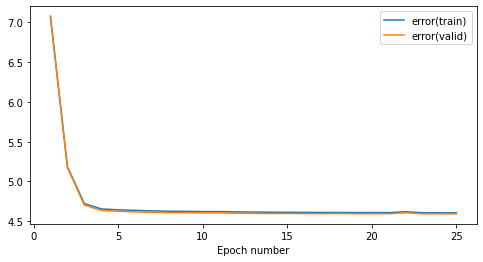

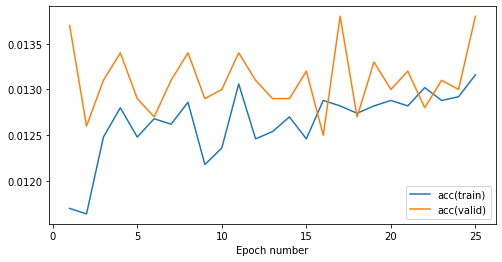

In [4]:
seed = 6102016 
rng = np.random.RandomState(seed)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]
train_data = MNISTAutoencoderDataProvider('train', rng=rng)
valid_data = MNISTAutoencoderDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 784
hidden_dim=50

# Set training run hyperparameters
batch_size = 50  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 25  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

param_init = UniformInit(-init_scale, init_scale, rng=rng)
error = SumOfSquaredDiffsError()


model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, param_init, param_init),
    AffineLayer(hidden_dim, output_dim, param_init, param_init)
])

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)


Using the function defined in the cell below (from the first lab notebook), plot a batch of the original images and the autoencoder reconstructions.

In [5]:
def show_batch_of_images(title,img_batch, fig_size=(3, 3), num_rows=None):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    if num_rows is None:
        # calculate grid dimensions to give square(ish) grid
        num_rows = int(batch_size**0.5)
    num_cols = int(batch_size * 1. / num_rows)
    if num_rows * num_cols < batch_size:
        num_cols += 1
    # intialise empty array to tile image grid into
    tiled = np.zeros((im_height * num_rows, im_width * num_cols))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % num_rows, i // num_rows
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys', vmin=0., vmax=1.)
    ax.set_title(title)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

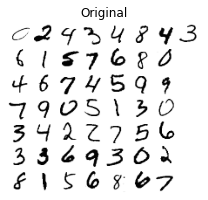

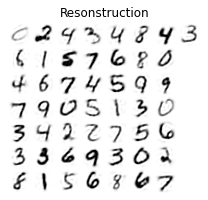

(<Figure size 216x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Resonstruction'}>)

In [6]:
inputs,targets=train_data.next()
reconstruction=model.fprop(inputs)[-1]
show_batch_of_images("Original",inputs.reshape(-1,28,28))
show_batch_of_images("Resonstruction",reconstruction.reshape(-1,28,28))

### Optional extension: principle components analysis

*This section is provided for the interest of those also sitting MLPR or otherwise already familiar with eigendecompositions and PCA. Feel free to skip over if this doesn't apply to you (or even if it does).*

For a linear (affine) contractive autoencoder model trained with a sum of squared differences error function there is an analytic solution for the optimal model parameters corresponding to [principle components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

If we have a training dataset of $N$ $D$-dimensional vectors $\left\lbrace \boldsymbol{x}^{(n)} \right\rbrace_{n=1}^N$, then we can calculate the empiricial mean and covariance of the training data using

\begin{equation}
  \boldsymbol{\mu} = \frac{1}{N} \sum_{n=1}^N \left[ \boldsymbol{x}^{(n)} \right]
  \qquad
  \text{and}
  \qquad
  \mathbf{\Sigma} = \frac{1}{N} 
  \sum_{n=1}^N \left[ 
    \left(\boldsymbol{x}^{(n)} - \boldsymbol{\mu} \right)
    \left(\boldsymbol{x}^{(n)} - \boldsymbol{\mu} \right)^{\rm T}
  \right].
\end{equation}

We can then calculate an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of the covariance matrix 
\begin{equation}
  \mathbf{\Sigma} = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^{\rm T}
  \qquad
  \mathbf{Q} = \left[ 
  \begin{array}{cccc}
  \uparrow & \uparrow & \cdots & \uparrow \\
  \boldsymbol{q}_1 & \boldsymbol{q}_2 & \cdots & \boldsymbol{q}_D \\
  \downarrow & \downarrow & \cdots & \downarrow \\
  \end{array}
  \right]
  \qquad
  \mathbf{\Lambda} = \left[ 
  \begin{array}{cccc} 
  \lambda_1 & 0 & \cdots & 0 \\
  0 & \lambda_2 & \cdots & \vdots \\
  \vdots & \vdots & \ddots & 0 \\ 
  0 & 0 & \cdots & \lambda_D \\ 
  \end{array} \right]
\end{equation}

with $\mathbf{Q}$ an orthogonal matrix, $\mathbf{Q}\mathbf{Q}^{\rm T} = \mathbf{I}$, with columns $\left\lbrace \boldsymbol{q}_d \right\rbrace_{d=1}^D$ corresponding to the eigenvectors of $\mathbf{\Sigma}$ and $\mathbf{\Lambda}$ a diagonal matrix with diagonal elements $\left\lbrace \lambda_d \right\rbrace_{d=1}^D$ the corresponding eigenvalues of $\mathbf{\Sigma}$. 

Assuming the eigenvalues are ordered such that $\lambda_1 < \lambda_2 < \dots < \lambda_D$ then the top $K$ principle components of the inputs (eigenvectors with largest eigenvalues) correspond to $\left\lbrace \boldsymbol{q}_d \right\rbrace_{d=D + 1 - K}^D$. If we define a $D \times K$ matrix $\mathbf{V} = \left[ \boldsymbol{q}_{D + 1 - K} ~ \boldsymbol{q}_{D + 2 - K} ~\cdots~ \boldsymbol{q}_D \right]$ then we can find the projections of a (mean normalised) input vector on to the selected $K$ principle components as $\boldsymbol{h} = \mathbf{V}^{\rm T}\left( \boldsymbol{x} - \boldsymbol{\mu}\right)$. We can then use these principle component projections to form a reconstruction of the original input just in terms of the $K$ top principle components using $\boldsymbol{r} = \mathbf{V} \boldsymbol{h} + \boldsymbol{\mu}$. We can see that this is just a sequence of two affine transformations and so is directly analagous to a model with two affine layers and with $K$ dimensional outputs of the first layer / inputs to second.

The function defined in the cell below will calculate the PCA solution for a set of input vectors and a defined number of components $K$. Use it to calculate the top 50 principle components of the MNIST training data. Use the returned matrix and mean vector to calculate the PCA based reconstructions of a batch of 50 MNIST images and use the `show_batch_of_images` function to plot both the original and reconstructed inputs alongside each other. Also calculate the sum of squared differences error for the PCA solution on the MNIST training set and compare to the figure you got by gradient descent based training above. Will the gradient based training produce the same hidden representations as the PCA solution if it is trained to convergence?

In [ ]:
def get_pca_parameters(inputs, num_components=50):
    mean = inputs.mean(0)
    inputs_zm = inputs - mean[None, :]
    covar = np.einsum('ij,ik', inputs_zm, inputs_zm)
    eigvals, eigvecs = np.linalg.eigh(covar)
    return eigvecs[:, -num_components:], mean

## Exercise 2: Non-linear autoencoders

Those who did the extension in the previous exercise will have just seen that for an autoencoder with both linear / affine encoder and decoders, there is an analytic solution for the parameters which minimise a sum of squared differences error.

In general the advantage of using gradient-based training methods is that it allows us to use non-linear models for which there is no analytic solution for the optimal parameters. The hope is the use of non-linear transformations between the affine transformation layers will increase the representational power of the model (a sequence of affine transformations applied without any interleaving non-linear operations can always be represented by a single affine transformation).

Train a contractive autoencoder with an initial affine layer (output dimension again 50) followed by a rectified linear layer, then an affine transformation projecting to outputs of same dimension as the original inputs, and finally a logistic sigmoid layer at the output. As the only layers with parameters are the two affine layers which have the same dimensions as in the fully affine model above, the overall model here has the same number of parameters as previously.

Again train for 25 epochs with 50 training examples per batch and use a uniform Glorot initialisation for the weights, and zero biases initialisation. Use our implementation of the 'Adam' adaptive moments learning rule (available in `mlp.learning_rules` as `AdamLearningRule`) rather than basic gradient descent here (the adaptivity helps deal with the varying appropriate scale of updates induced by the non-linear transformations in this model).

In [7]:
import sys
sys.path.append('C:/Users/admin/Desktop/mlpractical')
import numpy as np
import logging
import mlp.layers as layers
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer,ReluLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError
import mlp.models as models
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
import mlp.optimisers as optimisers
from mlp.optimisers import Optimiser
import mlp.errors as errors
import mlp.learning_rules as learning_rules
import mlp.data_providers as data_providers
import mlp.initialisers as initialisers
import matplotlib.pyplot as plt
from mlp.data_providers import MNISTAutoencoderDataProvider,MNISTDataProvider
from mlp.learning_rules import GradientDescentLearningRule
%matplotlib inline

Epoch 1: 2.1s to complete
    error(train)=1.80e+01, acc(train)=1.04e-02, error(valid)=1.78e+01, acc(valid)=1.08e-02
Epoch 2: 2.1s to complete
    error(train)=1.34e+01, acc(train)=1.06e-02, error(valid)=1.32e+01, acc(valid)=1.20e-02
Epoch 3: 1.7s to complete
    error(train)=1.08e+01, acc(train)=1.06e-02, error(valid)=1.06e+01, acc(valid)=1.14e-02
Epoch 4: 1.7s to complete
    error(train)=8.93e+00, acc(train)=1.05e-02, error(valid)=8.80e+00, acc(valid)=1.01e-02
Epoch 5: 1.8s to complete
    error(train)=7.47e+00, acc(train)=1.10e-02, error(valid)=7.39e+00, acc(valid)=1.04e-02
Epoch 6: 1.7s to complete
    error(train)=6.39e+00, acc(train)=1.12e-02, error(valid)=6.34e+00, acc(valid)=1.10e-02
Epoch 7: 1.9s to complete
    error(train)=5.70e+00, acc(train)=1.15e-02, error(valid)=5.66e+00, acc(valid)=1.16e-02
Epoch 8: 1.7s to complete
    error(train)=5.21e+00, acc(train)=1.22e-02, error(valid)=5.18e+00, acc(valid)=1.22e-02
Epoch 9: 1.8s to complete
    error(train)=4.83e+00, acc(train)=

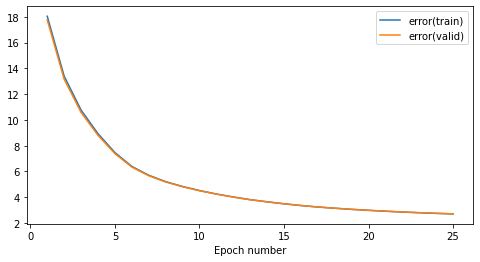

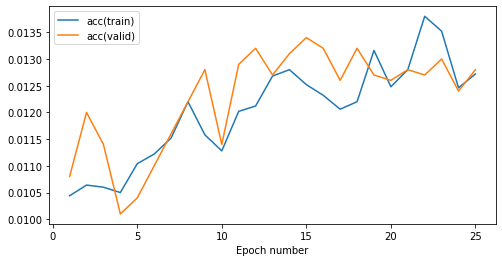

In [8]:

seed = 6102016 
rng = np.random.RandomState(seed)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]
train_data = MNISTAutoencoderDataProvider('train', rng=rng)
valid_data = MNISTAutoencoderDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 784
hidden_dim=50

# Set training run hyperparameters
batch_size = 50  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 25  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

param_init = UniformInit(-init_scale, init_scale, rng=rng)
error = SumOfSquaredDiffsError()


model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, param_init, param_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, param_init, param_init),
    SigmoidLayer()
])

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

Plot batches of the inputs and reconstructed inputs for this non-linear contractive autoencoder model and compare to the corresponding plots for the linear models above.

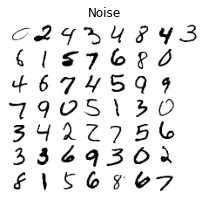

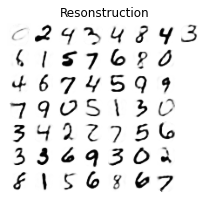

(<Figure size 216x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Resonstruction'}>)

In [9]:
inputs,targets=train_data.next()
reconstruction=model.fprop(inputs)[-1]
show_batch_of_images("Noise",inputs.reshape(-1,28,28))
show_batch_of_images("Resonstruction",reconstruction.reshape(-1,28,28))

## Exercise 3: Denoising autoencoders

So far we have just considered autoencoders that try to reconstruct the input vector fed into them via some intermediate lower-dimensional 'contracted' representation. The contraction is important as if we were to mantain the input dimensionality in all layers of the model a trivial optima for the model to learn would be to apply an identity transformation at each layer.

It can be desirable for the intermediate hidden representation to be robust to noise in the input. The intuition is that this will force the model to learn to maintain the 'important structure' in the input in the hidden representation (that needed to reconstruct the input). This also removes the requirement to have a contracted hidden representation (as the model can no longer simply learn to apply an identity transformation) though in practice we will still often use a lower-dimensional hidden representation as we believe there is a certain level of redundancy in the input data and so the important structure can be represented with a lower dimensional representation.

Create a new data provider object which adds to noise to the inputs to an autoencoder in each batch it returns. There are various different ways you could introduce noise. The three suggested in the lecture slides are

  * *Gaussian*: add independent, zero-mean Gaussian noise of a fixed standard-deviation to each dimension of the input vectors.
  * *Masking*: generate a random binary mask and perform an elementwise multiplication with each input (forcing some subset of the values to zero).
  * *Salt and pepper*: select a random subset of values in each input and randomly assign either zero or one to them.
  
You should choose one of these noising schemes to implement. It may help to know that the base `DataProvider` object already has access to a random number generator object as its `self.rng` attribute.

In [10]:
class MNISTAutoencoderDataProvider(MNISTDataProvider):
    """Simple wrapper data provider for training an autoencoder on MNIST."""

    def next(self):
        """Returns next data batch or raises `StopIteration` if at end."""
        inputs_batch, targets_batch = super(
            MNISTAutoencoderDataProvider, self).next()
        # return inputs as targets for autoencoder training
        return inputs_batch+np.random.normal(0, 1, inputs_batch.shape), inputs_batch+np.random.normal(0, 1, inputs_batch.shape)

Epoch 1: 4.6s to complete
    error(train)=4.12e+02, acc(train)=6.82e-03, error(valid)=4.12e+02, acc(valid)=7.00e-03
Epoch 2: 4.2s to complete
    error(train)=4.09e+02, acc(train)=7.28e-03, error(valid)=4.09e+02, acc(valid)=7.70e-03
Epoch 3: 4.2s to complete
    error(train)=4.07e+02, acc(train)=8.48e-03, error(valid)=4.07e+02, acc(valid)=7.00e-03
Epoch 4: 4.1s to complete
    error(train)=4.06e+02, acc(train)=7.66e-03, error(valid)=4.06e+02, acc(valid)=7.00e-03
Epoch 5: 4.2s to complete
    error(train)=4.06e+02, acc(train)=8.00e-03, error(valid)=4.06e+02, acc(valid)=6.80e-03
Epoch 6: 4.3s to complete
    error(train)=4.05e+02, acc(train)=8.48e-03, error(valid)=4.05e+02, acc(valid)=7.70e-03
Epoch 7: 4.7s to complete
    error(train)=4.05e+02, acc(train)=8.26e-03, error(valid)=4.05e+02, acc(valid)=7.30e-03
Epoch 8: 4.3s to complete
    error(train)=4.05e+02, acc(train)=7.40e-03, error(valid)=4.04e+02, acc(valid)=7.70e-03
Epoch 9: 4.3s to complete
    error(train)=4.05e+02, acc(train)=

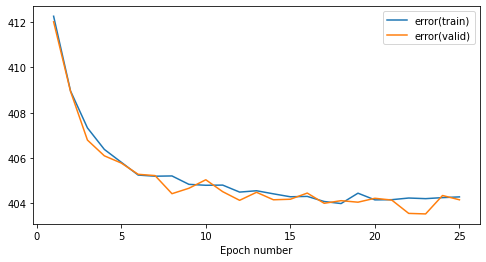

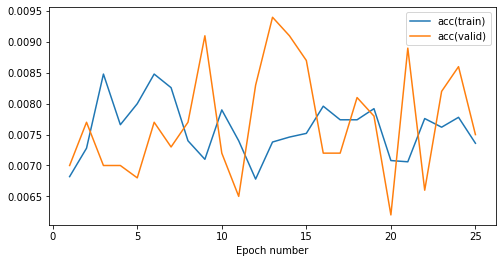

In [11]:
seed = 6102016 
rng = np.random.RandomState(seed)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]
train_data = MNISTAutoencoderDataProvider('train', rng=rng)
valid_data = MNISTAutoencoderDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 784
hidden_dim=50

# Set training run hyperparameters
batch_size = 50  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.01  # learning rate for gradient descent
num_epochs = 25  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

param_init = UniformInit(-init_scale, init_scale, rng=rng)
error = SumOfSquaredDiffsError()


model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, param_init, param_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, param_init, param_init),
    SigmoidLayer()
])

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

Once you have implemented your chosen scheme, use the new data provider object to train a denoising autoencoder with the same model architecture as in exercise 2.

Use the `show_batch_of_images` function from above to visualise a batch of noisy inputs from your data provider implementation and the denoised reconstructions from your trained denoising autoencoder.

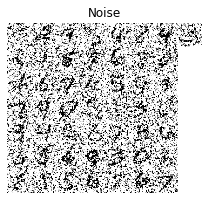

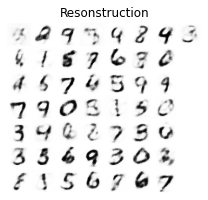

(<Figure size 216x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Resonstruction'}>)

In [12]:
inputs,targets=train_data.next()
reconstruction=model.fprop(inputs)[-1]
show_batch_of_images("Noise",inputs.reshape(-1,28,28))
show_batch_of_images("Resonstruction",reconstruction.reshape(-1,28,28))

## Exercise 4: Using an autoencoder as an initialisation for supervised training

As a final exercise we will use the first layer of an autoencoder for MNIST digit images as a layer within a multiple layer model trained to do digit classification. The intuition behind pretraining methods like this is that the hidden representations learnt by an autoencoder should be a more useful representation for training a classifier than the raw pixel values themselves. We could fix the parameters in the layers taken from the autoencoder but generally we can get better performance by letting the whole model be trained end-to-end on the supervised training task, with the learnt autoencoder parameters in this case acting as a potentially more intelligent initialisation than randomly sampling the parameters which can help ease some of the optimisation issues encountered due to poor initialisation of a model.

You can either use one of the autoencoder models you trained in the previous exercises, or train a new autoencoder model for specifically for this exercise. Create a new model object (instance of `mlp.models.MultipleLayerModel`) in which the first layer(s) of the list of layer passed to the model constructor are the trained first layer(s) from your autoencoder model (these can be accessed via the `layers` attribute which is a list of all the layers in a model). Add any additional layers you wish to the pretrained layers - at the very least you will need to add an output layer with output dimension 10 to allow the model to be used to predict class labels. Train this new model on the original MNIST image, digit labels pairs with a cross entropy error. 